## Study Analysis

### Venue distribution and ranking

CORE ranking for conferences: https://portal.core.edu.au/conf-ranks/

SJR rankings for journals: https://www.scimagojr.com/journalsearch.php

In [17]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import plotly.colors as pc
import plotly.graph_objects as go
import plotly.colors as pc
import plotly.io as pio
import json
import os
import re
import h5py
pio.renderers.default = "vscode"

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import AutoMinorLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from collections import defaultdict
from collections import Counter
from pathlib import Path

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]
plt.rcParams["mathtext.fontset"] = "dejavuserif" 

sns.set_theme(style="white")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)         # Prevents wrapping
pd.set_option('display.max_colwidth', None)  # Shows full content in each cell

In [18]:
# conference CORE ranking
A_ = set(["INFOCOM", "ICSE", "ESEC/FSE", "USENIX Security", "ACL", "SP", "EMNLP", "ASE", "NDSS", "ICLR"])
A = set(["NAACL", "MSR", "ACSAC", "ISSRE", "RAID", "EuroS&P", "ICST", "ESORICS", "DSN", "SANER", "ICPC", "ICSME", "ISSTA", "EASE", "ASIACCS"])
B = set(["ICTAI", "IJCNN", "TrustCom", "ICASSP", "BigData", "SSE"])
C = set(["QRS", "ISCC", "SCAM", "ISMM", "CIT", "ICMLA", "SECRYPT", "APSEC", "SecureComm"])

# journal Quartile ranking
Q1 = set(["JISA", "EMSE", "TSE", "TOSEM", "IEEE Access", "TDSC", "COSE", "JSS", "PACMPL", "Information Fusion", "Cluster Computing", "IST", "Neural Comput. Appl."])
Q2 = set(["Soft Computing", "Applied Sciences", "IJNM", "Mathematics", "The Journal of Supercomputing", "Future Internet", "Information", "Electronics", "IJCIS", "ASE", "JIIS", "IJIS"])


def _bib_lookup(bibtex: str, field: str) -> str | None:
    pat = rf"(?im)^\s*{re.escape(field)}\s*=\s*\{{+\s*(.*?)\s*\}}+"
    m = re.search(pat, bibtex)
    return m.group(1).strip() if m else None

def _venue_from_bib(bibtex: str) -> str:
    """
    Return a concise venue string.

    Priority
    --------
    1. Abbreviation in parentheses, e.g. “… (TrustCom)”  →  TrustCom
    2. Journals  → full journal name (unless #1 matched).
    3. Booktitles
       • first ALL-CAPS word ≥ 2 chars  (CVPR, ICLR …),
         else full booktitle.
    4. Fallback  → 'arXiv' (if arXiv preprint) or 'Unknown'.
    """

    def paren_abbrev(text: str) -> str | None:
        """Return text inside first (...) that contains at least one letter."""
        m = re.search(r"\(([^)]+)\)", text)
        if m:
            cand = m.group(1).strip()
            return cand if re.search(r"[A-Za-z]", cand) else None
        return None

    journal = _bib_lookup(bibtex, "journal")
    if journal:
        return paren_abbrev(journal) or journal.strip()

    book = _bib_lookup(bibtex, "booktitle")
    if book:
        abbrev = paren_abbrev(book)
        if abbrev:
            return abbrev

        big = next((w for w in book.split() if w.isupper() and len(w) > 1), None)
        return big or book.strip()

    return "arXiv" if "arxiv" in bibtex.lower() else "Unknown"

def get_entry_type(bib: str) -> str:
    bib = bib.lower()
    if "@inproceedings" in bib:
        return "conference"
    if "@article" in bib:
        return "journal"
    if "arxiv" in bib:
        return "arxiv"
    return "other"


def classify_ranking(venue: str, entry_type: str) -> str:
    venue_norm = venue.strip()

    # Conferences
    if entry_type == "conference":
        if venue_norm in A_: return "A*"
        if venue_norm in A:     return "A"
        if venue_norm in B:     return "B"
        if venue_norm in C:     return "C"
        return "Unranked"

    # Journals
    if entry_type == "journal":
        if venue_norm in Q1: return "Q1"
        if venue_norm in Q2: return "Q2"
        return "Unranked"

    return "NA"

In [19]:
# Load the 'STUDY_META' sheet from taxonomy
taxonomy_df = pd.read_excel("./taxonomy.xlsx", sheet_name="STUDY_META")

taxonomy_df['First-Published'] = pd.to_datetime(taxonomy_df['First-Published'], format='%b-%y', errors='coerce')
taxonomy_df['Current-Version'] = pd.to_datetime(taxonomy_df['Current-Version'], format='%b-%y', errors='coerce')
taxonomy_df['First-Published'] = taxonomy_df['First-Published'].dt.strftime('%b-%Y')
taxonomy_df['Current-Version'] = taxonomy_df['Current-Version'].dt.strftime('%b-%Y')
taxonomy_df = taxonomy_df.fillna("None")

In [20]:
# extract venue for each paper
taxonomy_df["venue"] = taxonomy_df["BibTex"].astype(str).apply(_venue_from_bib)
taxonomy_df["entry_type"] = taxonomy_df["BibTex"].astype(str).apply(get_entry_type)
taxonomy_df["ranking"] = taxonomy_df.apply(lambda row: classify_ranking(row["venue"], row["entry_type"]), axis=1)

print(f'total number of studies: {taxonomy_df["venue"].value_counts().sum()}')
print(f'number of unique venues: {taxonomy_df["venue"].nunique()}')

total number of studies: 263
number of unique venues: 117


In [22]:
venue_stats = taxonomy_df.groupby(["venue", "entry_type", "ranking"]).size().reset_index(name="count")

venue_stats_sorted = venue_stats.sort_values("ranking", ascending=True)
display(venue_stats_sorted)

,venue,entry_type,ranking,count
34,EASE,conference,A,1
62,ICST,conference,A,1
57,ICPC,conference,A,1
98,SANER,conference,A,2
13,ASIACCS,conference,A,1
96,RAID,conference,A,1
33,DSN,conference,A,1
89,NAACL,conference,A,1
60,ICSME,conference,A,1
75,ISSTA,conference,A,2


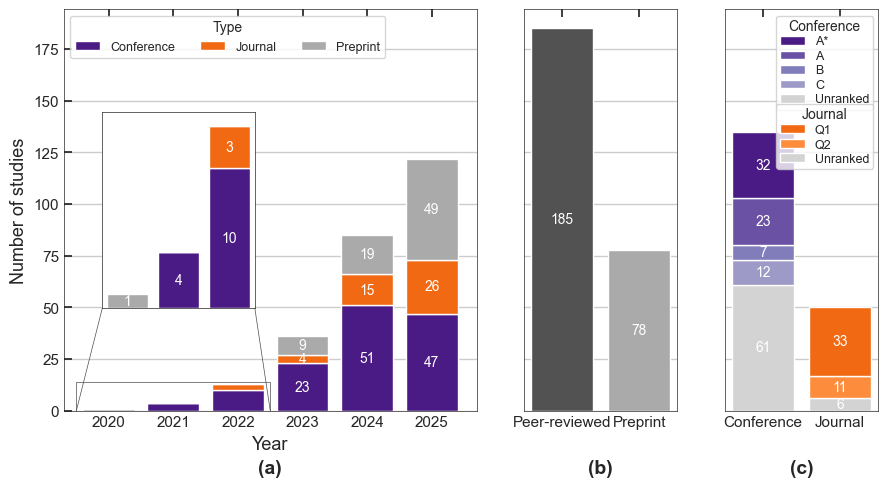

In [23]:
# Study Analysis
# ==============================

# Aggregate counts for conferences
conf_df = taxonomy_df[taxonomy_df["entry_type"] == "conference"]
conf_counts = conf_df["ranking"].value_counts()

# Ensure consistent ordering 
conf_order = ["Unranked", "C", "B", "A", "A*"]
conf_values = [conf_counts.get(label, 0) for label in conf_order]

# Aggregate counts for journals
journal_df = taxonomy_df[taxonomy_df["entry_type"] == "journal"]
journal_counts = journal_df["ranking"].value_counts()

journal_order = ["Unranked", "Q2", "Q1"]
journal_values = [journal_counts.get(label, 0) for label in journal_order]

taxonomy_df["year"] = taxonomy_df["BibTex"].str.extract(r"year\s*=\s*[{\"]?(\d{4})")
taxonomy_df["year"] = taxonomy_df["year"].astype(int)

# Restrict to 2020–2025
mask = taxonomy_df["year"].between(2020, 2025)
df_year = taxonomy_df[mask]

year_type_counts = (
    df_year
    .groupby(["year", "entry_type"])
    .size()
    .unstack(fill_value=0)
)

years = list(range(2020, 2026))
types = ["conference", "journal", "arxiv"]

year_type_counts = (
    year_type_counts
    .reindex(index=years, fill_value=0)
    .reindex(columns=types, fill_value=0)
)

pretty_label = {"conference": "Conference", "journal": "Journal", "arxiv": "Preprint"}
colors = {
    "conference": "#4B1B85",  # green
    "journal":    "#f16913",  # blue
    "arxiv":      "#aaaaaa"
}

# ==============================
# Data prep (peer-reviewed vs arXiv)
# ==============================

peer_reviewed_count = taxonomy_df[taxonomy_df["entry_type"].isin(["conference", "journal"])].shape[0]
arxiv_count = taxonomy_df[taxonomy_df["entry_type"] == "arxiv"].shape[0]

# ==============================
# Figure with 3 subplots
# ==============================

fig, axes = plt.subplots(
    1, 3,
    figsize=(10.5, 5.5),
    sharey=True,
    gridspec_kw={"width_ratios": [2.7, 1, 1]}
) # (a), (b), (c)
ax_a, ax_b, ax_c = axes

# ---------- (a) Papers per year by type ----------
# fig_a, ax_a = plt.subplots(figsize=(5.74, 4))
bottom = np.zeros(len(years))
x_years = np.arange(len(years))

for t in types:
    vals = year_type_counts[t].values
    ax_a.bar(x_years, vals, bottom=bottom, color=colors[t], label=pretty_label[t])
    bottom += vals

# --- Inset zoom for years 2020–2022 ---
# create inset axes inside ax_a
axins = inset_axes(
    ax_a,
    width="37%",   # relative to ax_a
    height="49%",
    loc="center left",  
    borderpad=2.5
)
zoom_years_idx = [0, 1, 2]   # indices in `years` for 2020, 2021, 2022
zoom_x = x_years[zoom_years_idx]

bottom_zoom = np.zeros(len(zoom_years_idx))
for t in types:
    vals = year_type_counts[t].values[zoom_years_idx]
    axins.bar(zoom_x, vals, bottom=bottom_zoom, color=colors[t])
    bottom_zoom += vals

# x/y limits so it zooms in correctly
axins.set_xlim(zoom_x[0] - 0.5, zoom_x[-1] + 0.5)
axins.set_ylim(0, max(bottom_zoom) + 1)  

# ticks / labels
# axins.set_xticks(zoom_x)
# axins.set_xticklabels([str(y) for y in years[:3]], fontsize=8)
# axins.tick_params(axis="y", labelsize=8)

bottom_zoom = np.zeros(len(zoom_years_idx))
for t in types:
    vals = year_type_counts[t].values[zoom_years_idx]
    for xi, v, b in zip(zoom_x, vals, bottom_zoom):
        if v > 0:
            axins.text(
                xi,
                b + v / 2.0,
                str(v),
                ha="center",
                va="center",
                fontsize=10, 
                color="white"
            )
    bottom_zoom += vals

# axins
axins.set_xticks([])
axins.set_yticks([])
axins.tick_params(
    axis="both",
    which="both",
    length=0,          # no tick lines
    labelbottom=False, # no x tick labels
    labelleft=False    # no y tick labels
)
for spine in axins.spines.values():
    spine.set_linewidth(0.5)

ax_a.set_xticks(x_years)
ax_a.set_xticklabels([str(y) for y in years])
ax_a.tick_params(axis="x", labelsize=11)
ax_a.tick_params(axis="y", labelsize=11)
ax_a.set_ylabel("Number of studies", fontsize=13)
ax_a.set_xlabel("Year", fontsize=13)
#ax_a.set_title("(a)")
ax_a.legend(title="Type", fontsize=9, title_fontsize=10, loc="upper left", ncols=3)

# Add labels for each stacked segment
type_code = {"conference": "C", "journal": "J", "arxiv": "P"}
bottom = np.zeros(len(years))
for t in types:
    vals = year_type_counts[t].values
    for idx, (xi, v, b) in enumerate(zip(x_years, vals, bottom)):
        if idx in [0, 1, 2]:  
            continue
        if v > 0:
            y = b + v / 2.0
            ax_a.text(
                xi, y, str(v),
                ha="center",
                va="center",
                fontsize=10,
                color="white"
            )
    bottom += vals

#ax_a.tick_params(axis='both', which='both', direction='in', top=True, left=True)

mark_inset(
    ax_a, axins,
    loc1=3,  # upper left corner of zoom box
    loc2=4,  # lower left corner of zoom box
    fc="none",  # no fill
    ec="0.3",   # line color
    lw=0.5      # line width
)
#ax_a.text(0.5, -0.18, "(a)", ha="center", va="top", transform=ax_a.transAxes)

# for spine in ax_a.spines.values():
#     spine.set_linewidth(0.5) 

# ax_a.tick_params(axis='both', which='both', direction='in', top=True)
# ax_a.set_ylim(0, 170)
# ax_a.yaxis.set_major_locator(MultipleLocator(20))
# ax_a.grid(axis="y", which="major", linewidth=0.8)

# fig_a.tight_layout()
# fig_a.subplots_adjust(bottom=0.15) 
# fig_a.savefig("../figures/paper_dist_a.pdf", bbox_inches="tight", dpi=800)

# ---------- (b) Peer-reviewed vs arXiv ----------
#fig_b, ax_b = plt.subplots(figsize=(2.2, 4))

bars_x = [0, 1]
bars_heights = [peer_reviewed_count, arxiv_count]
bars_labels = ["Peer-reviewed", "Preprint"]
bars_colors = ["#525252", "#aaaaaa"]

ax_b.bar(bars_x, bars_heights, color=bars_colors)
ax_b.set_xticks(bars_x)
ax_b.set_xticklabels(bars_labels)
ax_b.tick_params(axis="x", labelsize=11)
ax_b.tick_params(axis="y", labelsize=11)
#ax_b.set_title("(b)")
ax_b.set_xlabel(" ", fontsize=11)

for xi, h in zip(bars_x, bars_heights):
    if h > 0:
        ax_b.text(
            xi, h / 2,            
            str(h),
            ha="center",
            va="center",
            fontsize=10,
            color="white"       
        )

# for spine in ax_b.spines.values():
#     spine.set_linewidth(0.5) 

# ax_b.set_ylim(0, 170)
# ax_b.yaxis.set_major_locator(MultipleLocator(20))
# ax_b.grid(axis="y", which="major", linewidth=0.8)

# # hide ticks/labels but keep locator alive for grid
# ax_b.tick_params(axis="y", which="both", left=False, labelleft=False)
# ax_b.tick_params(axis='both', which='both', direction='in', top=True)

# fig_b.tight_layout()
# fig_b.subplots_adjust(bottom=0.15)
# fig_b.savefig("../figures/paper_dist_b.pdf", bbox_inches="tight", dpi=800)

# ---------- (c) Study distribution by ranking ----------
#fig_c, ax_c = plt.subplots(figsize=(2.2, 4))

conf_colors = {
    "A*": "#4B1B85",
    "A":  "#6a51a3",
    "B":  "#807dba",
    "C":  "#9e9ac8",
    "Unranked": "lightgray",
}

journal_colors = {
    "Q1": "#f16913",
    "Q2": "#fd8d3c",
    "Unranked": "lightgray",
}

x = [0, 1]
conf_handles, conf_labels = [], []
journal_handles, journal_labels = [], []

# conference stacked bar
bottom = 0
for label, val in zip(conf_order, conf_values):
    if val == 0:
        continue
    h = ax_c.bar(x[0], val, bottom=bottom, color=conf_colors.get(label, "lightgray"))
    bottom += val
    conf_handles.append(h[0])
    conf_labels.append(label)

# journal stacked bar
bottom = 0
for label, val in zip(journal_order, journal_values):
    if val == 0:
        continue
    h = ax_c.bar(x[1], val, bottom=bottom, color=journal_colors.get(label, "lightgray"))
    bottom += val
    journal_handles.append(h[0])
    journal_labels.append(label)

ax_c.set_xticks(x)
ax_c.set_xticklabels(["Conference", "Journal"])
ax_c.tick_params(axis="x", labelsize=11)
ax_c.tick_params(axis="y", labelsize=11)
#ax_c.set_title("(c)")
ax_c.set_xlabel(" ", fontsize=11)

# legend ordering
conf_order_legend = ["A*", "A", "B", "C", "Unranked"]
journal_order_legend = ["Q1", "Q2", "Unranked"]

conf_map = {label: handle for handle, label in zip(conf_handles, conf_labels)}
journal_map = {label: handle for handle, label in zip(journal_handles, journal_labels)}

conf_handles_ord = [conf_map[l] for l in conf_order_legend if l in conf_map]
conf_labels_ord  = [l for l in conf_order_legend if l in conf_map]

journal_handles_ord = [journal_map[l] for l in journal_order_legend if l in journal_map]
journal_labels_ord  = [l for l in journal_order_legend if l in journal_map]

conf_legend = ax_c.legend(
    conf_handles_ord,
    conf_labels_ord,
    title="Conference",
    loc="upper right",
    bbox_to_anchor=(1.01, 1.0),   # near top-right, inside axes
    frameon=True,
    title_fontsize=10,
    fontsize=9,
    borderpad=0.3,
    labelspacing=0.2,
)
ax_c.add_artist(conf_legend) 

ax_c.legend(
    journal_handles_ord,
    journal_labels_ord,
    title="Journal",
    loc="upper right",
    bbox_to_anchor=(1.01, 0.78),   # same x, lower y
    frameon=True,
    title_fontsize=10,
    fontsize=9,
    borderpad=0.3,
    labelspacing=0.2,
)

# Conference labels
bottom = 0
for label, val in zip(conf_order, conf_values):
    if val > 0:
        ax_c.text(
            x[0], bottom + val/2, str(val),
            ha="center", va="center",
            fontsize=10, color="white"
        )
        bottom += val

# Journal labels
bottom = 0
for label, val in zip(journal_order, journal_values):
    if val > 0:
        ax_c.text(
            x[1], bottom + val/2, str(val),
            ha="center", va="center",
            fontsize=10, color="white"
        )
        bottom += val

ax_a.text(0.5, -0.12, "(a)", ha="center", va="top", transform=ax_a.transAxes, fontweight="bold", fontsize=14) 
ax_b.text(0.5, -0.12, "(b)", ha="center", va="top", transform=ax_b.transAxes, fontweight="bold", fontsize=14) 
ax_c.text(0.5, -0.12, "(c)", ha="center", va="top", transform=ax_c.transAxes, fontweight="bold", fontsize=14) 

for ax in (ax_a, ax_b, ax_c): # Thinner axes borders 
    for spine in ax.spines.values(): 
        spine.set_linewidth(0.5) 
    #ax.xaxis.set_minor_locator(AutoMinorLocator(n=1)) 
    #ax.yaxis.set_minor_locator(AutoMinorLocator(n=2)) 
    ax.tick_params(axis='both', which='both', direction='in', top=True) 
    ax.grid(axis="y") 
    ax_a.tick_params(axis='both', which='both', direction='in', top=True, left=True) 
    
#fig.tight_layout() 
fig.subplots_adjust(bottom=0.15) 
#fig.savefig("../figures/paper_distribution_combined.pdf", format="pdf", bbox_inches="tight", dpi=800) 
plt.show()